<a href="https://colab.research.google.com/github/trachtok/dspracticum2020_data/blob/main/assignment08/assignment08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of genomic sequences
*Kája Trachtová, Michaela Kecskésová, Martin Špilar, Dagmar Al Tukmachi*

+ the goal of this assignment was to train NN classifier over several classes of DNA sequences and beat a simple benchmark
+ input is G-quadruplexes data: https://github.com/simecek/dspracticum2020/tree/master/lecture_08/assignment/g4
+ how to do embedding inspired by https://www.tensorflow.org/tutorials/keras/text_classification

# Load libraries

In [1]:
!pip install biopython

     |████████████████████████████████| 2.3MB 13.9MB/s 


In [2]:
import urllib.request
from pathlib import Path
from Bio import SeqIO
import numpy as np
import gzip
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Reshaping data from FASTA to txt
+ data are stored in folders train & valid in FASTA format -> first its neccessary to extract only sequences

In [20]:
classes = ['notpresent', 'present']
sets = ['train', 'valid']

for c in classes:
    for s in sets:
        urllib.request.urlretrieve(f"https://github.com/simecek/dspracticum2020/raw/master/lecture_08/assignment/g4/g4_{c}_{s}.fa.gz", f"g4_{c}_{s}.fa.gz")

for c in classes:
    for s in sets:
        Path(f"data/{s}/{c}").mkdir(parents=True, exist_ok=True)

for c in classes:
    for s in sets:
        with gzip.open(f"g4_{c}_{s}.fa.gz", "rt") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                id = record.id
                with open(f"data/{s}/{c}/{id}.txt", "w") as fw:
                    fw.writelines([" ".join(str(record.seq))])


## Reading input data
+ read training and validation datasets

In [21]:
batch_size = 128

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/train/',
    batch_size=batch_size,
    class_names=classes)

Found 210000 files belonging to 2 classes.


In [22]:
# Look at some example sequences
for seq_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Sequence", seq_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Sequence b'G C T A A T G A G T G A G T G A C A A A C C C A G G A G T C C A A C T T T G G A G T C T C C A A C C C C T C A A G C C C T C T G C T T T T C T G C C C T T T T T G T C A T T A T T C A A G A T G C T T C A C T G G G A A G G G G A G A G G G G G G A A G A G G G G G A G A A G A A A A G C G T A A T G G A A A C C A C A T G G T A T T G G T G G G G G C C A C T C A A G A A T A G T G C T T C A C G G T T A C A'
Label 1
Sequence b'N N N N T A C T C G A T T C A T T C C A G G T C G T T C T G G T C A G T C G T C C G C C C G T C C G A G G T G T A G G A C T G T A A G G G C G G A G G G G A G G T C C C T A A A A G G T G G T A G A G T G A G A C C T T G A G A C A G A G G T T T G G T G T T C G A C T G T A G T G T G T C C C T C A G T G A C C T G C G G G G G A T C C T T T A N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N'
Label 1
Sequence b'N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N T T A A G C A G A A A G A A C A A C A T A T A G G C T G G G T G C

In [24]:
# See labels
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to notpresent
Label 1 corresponds to present


In [25]:
raw_valid_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/valid/',
    batch_size=batch_size,
    class_names=classes)

Found 90000 files belonging to 2 classes.


# Vectorization

In [26]:
vectorize_layer = TextVectorization(output_mode='int')

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
# vectorize_layer.set_vocabulary(vocab=np.asarray(['a', 'c', 't', 'g', 'n'])) -> if one-hot encoding instead of embedding is used

In [27]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
  # originally with one-hot encoding: return vectorize_layer(text)-2, label

train_ds = raw_train_ds.map(vectorize_text)
valid_ds = raw_valid_ds.map(vectorize_text)

In [28]:
# retrieve a batch (of 32 sequences and labels) from the dataset
seq_batch, label_batch = next(iter(raw_train_ds))
first_seq, first_label = seq_batch[0], label_batch[0]
print("Seq", first_seq)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized seq", vectorize_text(first_seq, first_label))

Seq tf.Tensor(b'G C A G C G G G G A C T G C A T C T G C A C G G A A T C C T A G T C T G C T C C C A C C T T C C C C C A G T G G C C A T T C T G A G C A G C C A G C A A A G T C C A A G G T T C T A G G A T A C T C G A G T C C C T C C C T C C A G G T A G G G C T G G G A T C G G G G A G G G C A A G A C G A G G G A A G A G G T G A G C A T C C C T G A A T A A T G C A T C C T G G C C T T A A A T G G C T C T T T G T T T', shape=(), dtype=string)
Label present
Vectorized seq (<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[3, 5, 2, 3, 5, 3, 3, 3, 3, 2, 5, 4, 3, 5, 2, 4, 5, 4, 3, 5, 2, 5,
        3, 3, 2, 2, 4, 5, 5, 4, 2, 3, 4, 5, 4, 3, 5, 4, 5, 5, 5, 2, 5, 5,
        4, 4, 5, 5, 5, 5, 5, 2, 3, 4, 3, 3, 5, 5, 2, 4, 4, 5, 4, 3, 2, 3,
        5, 2, 3, 5, 5, 2, 3, 5, 2, 2, 2, 3, 4, 5, 5, 2, 2, 3, 3, 4, 4, 5,
        4, 2, 3, 3, 2, 4, 2, 5, 4, 5, 3, 2, 3, 4, 5, 5, 5, 4, 5, 5, 5, 4,
        5, 5, 2, 3, 3, 4, 2, 3, 3, 3, 5, 4, 3, 3, 3, 2, 4, 5, 3, 3, 3, 3,
        2, 3, 3, 3, 5, 2, 2, 3, 2, 5

In [29]:
# lookup the token (string) that each integer corresponds to 
print("0 ---> ",vectorize_layer.get_vocabulary()[0]) # why there is no 0? Look below to see what I mean, all numbers have assigned nukleotide but not 0
print(" 1 ---> ",vectorize_layer.get_vocabulary()[1])
print(" 2 ---> ",vectorize_layer.get_vocabulary()[2])
print(" 3 ---> ",vectorize_layer.get_vocabulary()[3])
print(" 4 ---> ",vectorize_layer.get_vocabulary()[4])
print(" 5 ---> ",vectorize_layer.get_vocabulary()[5])
print(" 6 ---> ",vectorize_layer.get_vocabulary()[6])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

0 --->  
 1 --->  [UNK]
 2 --->  a
 3 --->  g
 4 --->  t
 5 --->  c
 6 --->  n
Vocabulary size: 7


## Model training

In [ ]:
# one-hot encoding - NOT USED
onehot_layer = keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x,'int64'), 4))

model_lstm = tf.keras.Sequential([
    onehot_layer,
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [30]:
# embedding
embedding_dim = 16
max_features = 7 # is 7 ok? I set it to the vocabulary size as in the text classification example mentioned at the beggining

model_lstm = tf.keras.Sequential([
    keras.layers.Embedding(max_features + 1, embedding_dim), # why +1 ?
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")]) 

opt = keras.optimizers.Adam(learning_rate=0.02)

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [31]:
epochs = 10 
history = model_lstm.fit(
    train_ds,
    epochs=epochs,
    validation_data = valid_ds)

Epoch 1/10
1641/1641 [==============================] - 125s 76ms/step - loss: 0.5478 - accuracy: 0.6833 - val_loss: 0.2954 - val_accuracy: 0.9079
Epoch 2/10
1641/1641 [==============================] - 130s 79ms/step - loss: 0.3204 - accuracy: 0.8911 - val_loss: 0.2872 - val_accuracy: 0.9145
Epoch 3/10
1641/1641 [==============================] - 134s 82ms/step - loss: 0.3501 - accuracy: 0.8643 - val_loss: 0.2291 - val_accuracy: 0.9196
Epoch 4/10
1641/1641 [==============================] - 137s 83ms/step - loss: 0.2175 - accuracy: 0.9268 - val_loss: 0.3175 - val_accuracy: 0.8888
Epoch 5/10
1641/1641 [==============================] - 140s 85ms/step - loss: 0.2030 - accuracy: 0.9271 - val_loss: 0.1710 - val_accuracy: 0.9398
Epoch 6/10
1641/1641 [==============================] - 137s 84ms/step - loss: 0.1699 - accuracy: 0.9395 - val_loss: 0.1662 - val_accuracy: 0.9415
Epoch 7/10
1641/1641 [==============================] - 138s 84ms/step - loss: 0.1523 - accuracy: 0.9437 - val_loss: 0

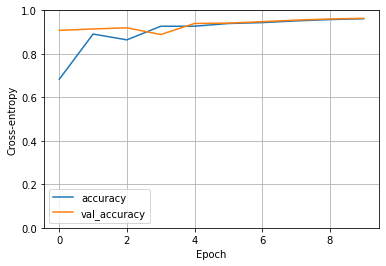

In [32]:
# plot training and validation accuracy
def plot_loss(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Cross-entropy')
  plt.legend()
  plt.grid(True)

plot_loss(history)